In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import sys
sys.path.insert(1, "../src/")
from _generate_time_series import *
from _clustering import *
import _tracking as tk

Defining the inputs and paranmeters:

In [5]:
# stiffness and mass: 
kx=np.array([2,2,2,2])*4000
ky=np.array([1.8,1.8,1.8,1.8])*4000
m=np.array([1,1,1,1])*500



#number of time series to run
n=50

#shapes for how the stiffnesses should behave trougout the time series:
shapey=np.sin(np.linspace(0,np.pi/2,n)) + 3
shapex=np.hstack((np.ones(n//2),np.linspace(1,3,n//2)))

#What modal orders to run in the cov-ssi:
orders=np.arange(2,50,1)

#sampling frequency and lengt of each time series:
fs=7        #Hz
T_max=3000  #sec
t=np.arange(0,T_max,1/fs)

# specify parameters for the load series: 
    # the general input for the amplutide of the white noise
white_noise_amp=1
    # whether or not to create new load series for each time segment
next_segment='new'
    #whether or not to greate indeviduel loadings for all DOFS
next_DOF='same'
    #Whether or not to include a harmonic part in the loading, and what type of 
    #harmonic function
harmonic='decreasing'
    #the the factor the amplitude of the harmonic is multiplied with 
    #the amplitude of the white noise
harmonic_part=0.2

### Noise fac for added measurments noice: 
noise_fac=1


Setting up the system and generating responses

In [6]:
true_w,_,responses=generate_dynamic_series(kx,ky,shapex,shapey,m,t,white_noise_amp,next_segment,next_DOF,harmonic,harmonic_part,plot=False)

Adding noise to the measurments:


In [7]:
responses_noised=add_noise_response(responses,noise_fac)

plot=False
if plot:
    ## plotting a comparison for one of the time series
    k=10   # what time segment to compare
    j=0    # waht response to compare (0=acceleration)

    figure=plt.figure(figsize=(6,10))
    for i in range(len(responses[k][j])):
        ax=plt.subplot2grid((6,1),(i,0),fig=figure)
        ax.plot(t,responses_noised[k][j][i],label='Noised response')
        ax.plot(t,responses[k][j][i],label='Response')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show(figure)



Run COV-ssi on the reasponses

In [8]:
lambds,phis=create_input_COVssi(responses,t,orders)

Plotting the output 

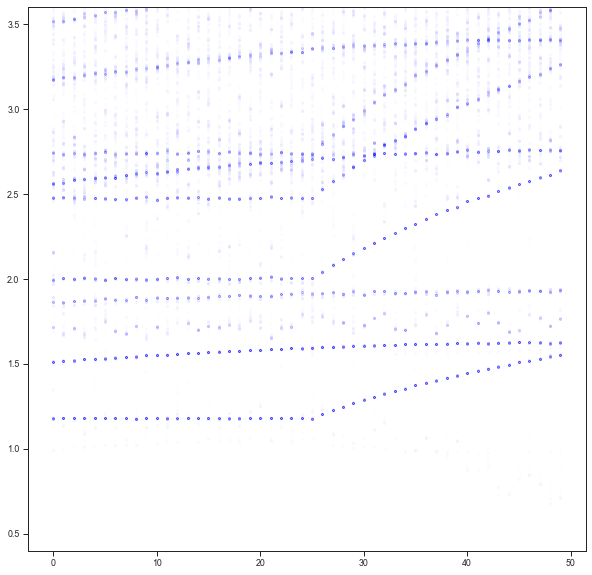

(0.4, 3.6)

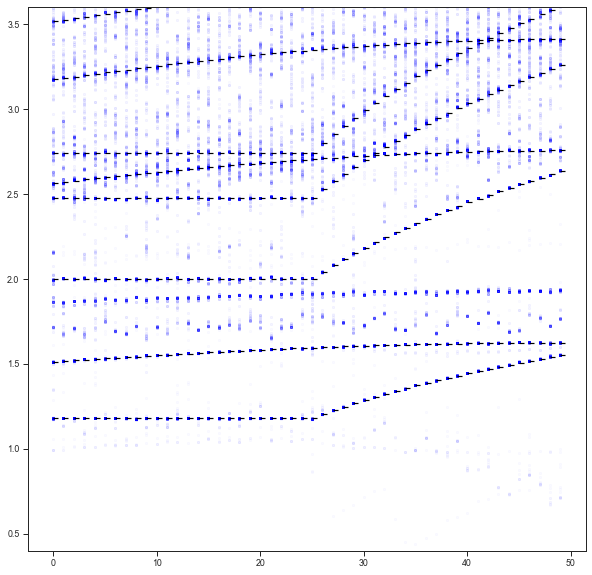

In [9]:
ys=create_output_guassian(lambds)

til_jon=ys.T

plt.figure(figsize=(10,10))
for k,s in enumerate(ys): 
    plt.scatter(s*0+k,s,s=6,alpha=0.005,color='blue')
plt.ylim(0.4,3.6)
plt.show()

plt.figure(figsize=(10,10))
for k,s in enumerate(ys): 
    plt.scatter(s*0+k,s,s=6,alpha=0.02,color='blue')
    plt.scatter(true_w[k]*0+k,true_w[k],color='black',marker=1)
plt.ylim(0.4,3.6)

Setting the parameters for the clustering:  

In [10]:
valid_range= { 'freq': [1e-4, np.inf],'damping': [1e-4,np.inf] }

indicator='freq'
s=1
stabcrit = {'freq':0.05, 'damping': 0.1, 'mac': 0.1}
prob_threshold = 0.5   #probability of pole to belong to 
# cluster, based on estimated "probability" density function

min_cluster_size=20 
min_samples=10
scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0}



The clustering call: 

In [11]:
phis_out,lambds_out=clustering(lambds,
phis,orders,s,stabcrit,valid_range,indicator,prob_threshold,
scaling,min_cluster_size,min_samples,true_w=true_w,plot=False)

c:\Users\jonkr\anaconda3\lib\site-packages\koma\clustering.py:46: RuntimeWarning: divide by zero encountered in true_divide
  diff = (arr1-arr2)/scaling
c:\Users\jonkr\anaconda3\lib\site-packages\koma\clustering.py:46: RuntimeWarning: invalid value encountered in true_divide
  diff = (arr1-arr2)/scaling
../src\_clustering.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  omega_n_auto=np.array(lambds_n_auto)**0.5
c:\Users\jonkr\anaconda3\lib\site-packages\koma\clustering.py:46: RuntimeWarning: divide by zero encountered in true_divide
  diff = (arr1-arr2)/scaling
c:\Users\jonkr\anaconda3\lib\site-packages\koma\clustering.py:46: RuntimeWarning: invalid value encountered in true_divide
  diff = (arr1-arr2)/scaling
../src\_clustering.py:70: VisibleDeprecationWarning: C

Plotter mode shapes


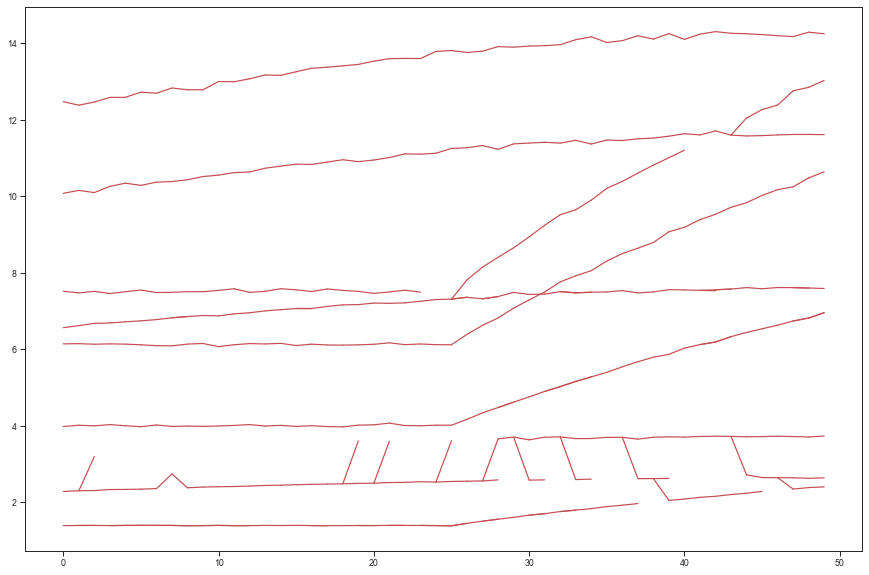

In [12]:
idf_track = tk.trackingAdvancedDistance(lambds_out, phis_out)
tk.tracking_plot(lambds_out, idf_track)

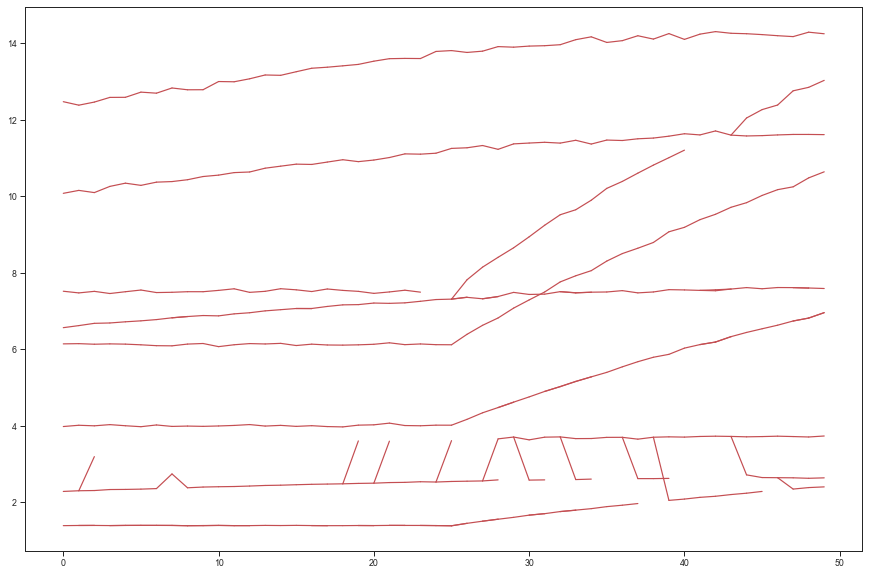

In [13]:
idf_track2 = tk.trackingMACDistance(lambds_out, phis_out)
tk.tracking_plot(lambds_out, idf_track2)

In [14]:
w_out = []
for i, row in enumerate(lambds_out):
    w_out.append(np.sqrt(row))

In [15]:
mode_traces = tk.perform_tracking(w_out, phis_out, n = 12, m = 5, d_track_threshold=0.3)

In [16]:
print(mode_traces)

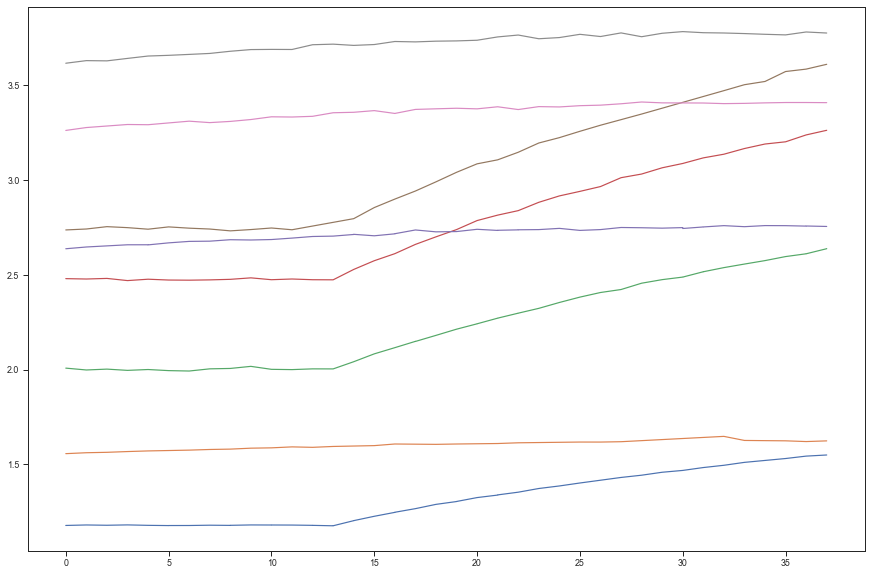

In [17]:
plt.figure(figsize=(15,10))
for i in range(len(mode_traces)):
    plt.plot(mode_traces[i].time_seg, mode_traces[i].frequencies)
    #print(mode_traces[i].ref_frequency)